# Clustering and Recommendations for Movies

| Contribution   |
| :---   |
| Leonardo Villamil  |
| Litian Chen        | 

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import sklearn
import math
import random
from scipy.sparse import csr_matrix
from scipy.cluster.hierarchy import dendrogram
from mpl_toolkits.axes_grid1 import make_axes_locatable
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import mean_squared_error
import itertools
from sklearn.metrics import silhouette_samples, silhouette_score
# np.random.SeedSequence(4)


In [2]:
movies = pd.read_csv('E:\OneDrive - Queensland University of Technology\MoProfEng\SEM-1\CAB420\Assignment1C\Data\Q1\movies.csv')
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [3]:
ratings = pd.read_csv(r'E:\OneDrive - Queensland University of Technology\MoProfEng\SEM-1\CAB420\Assignment1C\Data\Q1\ratings.csv')
ratings.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [4]:
print('The dataset contains: ', len(ratings), ' ratings of ', len(movies), ' movies.')

The dataset contains:  100836  ratings of  9742  movies.


In [5]:
search_reference = pd.DataFrame()
search_reference = ratings.drop(columns=['timestamp'])
search_reference['title'] = pd.Series(0, index=search_reference.index)
search_reference['genres'] = pd.Series(0, index=search_reference.index)
for o in range(5):    
    for p in range(len(movies)):
        if search_reference.iat[o,1].astype(int) == movies.iat[p,0].astype(int):
            # print(movies.iat[p,1])
            search_reference.iloc[o,3] = movies.iat[p,1]
            search_reference.iloc[o,4] = movies.iat[p,2]
            break
            # search_reference['title'] = pd.Series(movies.iat[p,1], index=search_reference.index)
            # search_reference['genres'] = pd.Series(movies.iat[p,2], index=search_reference.index)
            # search_reference['title'] = movies.iat[j,1]
            # search_reference = search_reference.append(movies.iat[j,1],ignore_index=True)

search_reference.head()

,userId,movieId,rating,title,genres
0,1,1,4.0,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,1,3,4.0,Grumpier Old Men (1995),Comedy|Romance
2,1,6,4.0,Heat (1995),Action|Crime|Thriller
3,1,47,5.0,Seven (a.k.a. Se7en) (1995),Mystery|Thriller
4,1,50,5.0,"Usual Suspects, The (1995)",Crime|Mystery|Thriller


In [6]:
# Function to get the genre ratings
def get_genre_ratings(ratings, movies, genres, column_names):
    genre_ratings = pd.DataFrame()
    for genre in genres:        
        genre_movies = movies[movies['genres'].str.contains(genre) ]
        avg_genre_votes_per_user = ratings[ratings['movieId'].isin(genre_movies['movieId'])].loc[:, ['userId', 'rating']].groupby(['userId'])['rating'].mean().round(2)
        
        genre_ratings = pd.concat([genre_ratings, avg_genre_votes_per_user], axis=1)
        
    genre_ratings.columns = column_names
    return genre_ratings

genre_ratings = get_genre_ratings(ratings, movies, ['Action','Adventure','Animation','Children','Comedy','Crime', 'Documentary','Drama','Fantasy','Film-Noir','Horror','Musical','Mystery','Romance','Sci-Fi','Thriller','War','Western'],['avg_action_rating','avg_adventure_rating','avg_animation_rating','avg_children_rating','avg_comedy_rating','avg_crime_rating','avg_documentary_rating','avg_drama_rating','avg_fantasy_rating','avg_film-noir_rating','avg_horror_rating','avg_musical_rating','avg_mystery_rating','avg_romance_rating', 'avg_sci-fi_rating','avg_thriller_rating','avg_war_rating','avg_western_rating'])
genre_ratings.head()

,avg_action_rating,avg_adventure_rating,avg_animation_rating,avg_children_rating,avg_comedy_rating,avg_crime_rating,avg_documentary_rating,avg_drama_rating,avg_fantasy_rating,avg_film-noir_rating,avg_horror_rating,avg_musical_rating,avg_mystery_rating,avg_romance_rating,avg_sci-fi_rating,avg_thriller_rating,avg_war_rating,avg_western_rating
1,4.32,4.39,4.69,4.55,4.28,4.36,NaN,4.53,4.30,5.0,3.47,4.68,4.17,4.31,4.22,4.15,4.50,4.29
2,3.95,4.17,NaN,NaN,4.00,3.80,4.33,3.88,NaN,NaN,3.00,NaN,4.00,4.50,3.88,3.70,4.50,3.50
3,3.57,2.73,0.50,0.50,1.00,0.50,NaN,0.75,3.38,NaN,4.69,0.50,5.00,0.50,4.20,4.14,0.50,NaN
4,3.32,3.66,4.00,3.80,3.51,3.81,4.00,3.48,3.68,4.0,4.25,4.00,3.48,3.38,2.83,3.55,3.57,3.80
5,3.11,3.25,4.33,4.11,3.47,3.83,NaN,3.80,4.14,NaN,3.00,4.40,4.00,3.09,2.50,3.56,3.33,3.00


In [7]:
for column in genre_ratings:
    genre_ratings[column] = genre_ratings[column].replace(np.nan, genre_ratings[column].mean())
genre_ratings.head()

,avg_action_rating,avg_adventure_rating,avg_animation_rating,avg_children_rating,avg_comedy_rating,avg_crime_rating,avg_documentary_rating,avg_drama_rating,avg_fantasy_rating,avg_film-noir_rating,avg_horror_rating,avg_musical_rating,avg_mystery_rating,avg_romance_rating,avg_sci-fi_rating,avg_thriller_rating,avg_war_rating,avg_western_rating
1,4.32,4.39,4.690000,4.550000,4.28,4.36,3.779776,4.53,4.300000,5.00000,3.47,4.680000,4.17,4.31,4.22,4.15,4.50,4.290000
2,3.95,4.17,3.639867,3.489785,4.00,3.80,4.330000,3.88,3.570549,3.84954,3.00,3.589766,4.00,4.50,3.88,3.70,4.50,3.500000
3,3.57,2.73,0.500000,0.500000,1.00,0.50,3.779776,0.75,3.380000,3.84954,4.69,0.500000,5.00,0.50,4.20,4.14,0.50,3.642476
4,3.32,3.66,4.000000,3.800000,3.51,3.81,4.000000,3.48,3.680000,4.00000,4.25,4.000000,3.48,3.38,2.83,3.55,3.57,3.800000
5,3.11,3.25,4.330000,4.110000,3.47,3.83,3.779776,3.80,4.140000,3.84954,3.00,4.400000,4.00,3.09,2.50,3.56,3.33,3.000000


Text(0.5, 0, 'Number of points in node (or index of point if no parenthesis).')

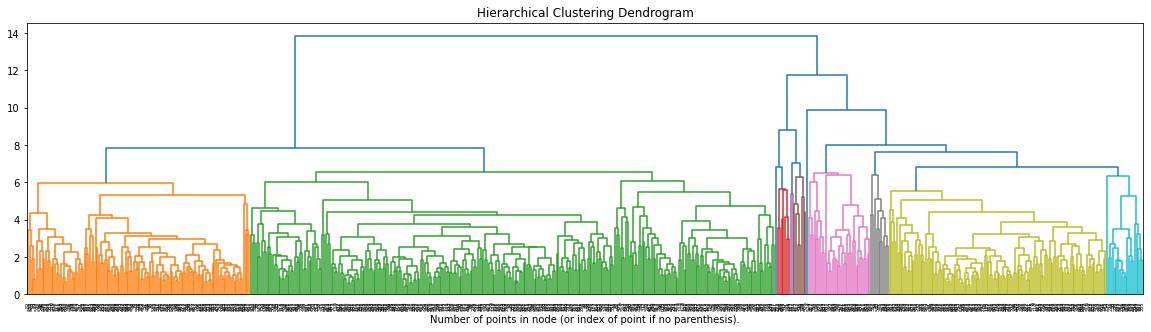

In [8]:
def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack([model.children_, model.distances_,
                                      counts]).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)
    
hac = AgglomerativeClustering(distance_threshold=20, n_clusters=None, linkage='complete',compute_full_tree=True)
hac = hac.fit(genre_ratings)

fig = plt.figure(figsize=[20, 5])
# ax = fig.add_subplot(1, 2, 1)
#for columns in range(len(genre_ratings)):
 #   ax.scatter(genre_ratings.iloc[columns,:], genre_ratings.row, c=hac.labels_)

ax = fig.add_subplot(1, 1, 1)
ax.set_title('Hierarchical Clustering Dendrogram')
# plot the top three levels of the dendrogram
plot_dendrogram(hac, p=3, color_threshold=6.7)
ax.set_xlabel("Number of points in node (or index of point if no parenthesis).")

In [9]:
hac = AgglomerativeClustering(distance_threshold=None, n_clusters=9, linkage='complete')
prediction = hac.fit_predict(genre_ratings)

In [10]:
def User_Movie_Recommendation(ratings, movies, userId):
    preference = prediction[userId]
    preference_genre_ratings = pd.DataFrame()
    preference_genre_avg_ratings = pd.DataFrame()
    user_watched = pd.DataFrame()
    user_have_same_preference = []
    mean = []
    test = []
    recomlist = []
    recomlist_name = []
    recomlist_name_random = []
    is_this_genre = []
    randomlist = np.empty(6, dtype = int)
    
    for i in range(len(prediction)):
        if prediction[i]==preference:
            user_have_same_preference = np.append(user_have_same_preference, [i])
            user_have_same_preference = user_have_same_preference.astype(np.int64)

    for j in range(len(user_have_same_preference)):
        holder = genre_ratings.iloc[user_have_same_preference[j]]
        preference_genre_ratings = preference_genre_ratings.append(holder,ignore_index=True)
    
    column = list(preference_genre_ratings)
    for k in range(len(column)):
        mean = np.append(mean, preference_genre_ratings[column[k]].mean())
    
    for l in range(len(mean)):
        preference_genre_avg_ratings.at[l,'genre'] = column[l]
        preference_genre_avg_ratings.at[l,'avg_rating'] = mean[l]
        test = np.append(test,[column[l],mean[l]])
    
    test = np.array(test.reshape(-1,2))

    sort = preference_genre_avg_ratings.sort_values(by='avg_rating', ascending=False, kind='quicksort').to_numpy()

    top3 = np.empty([3], dtype = object)
    top3[0] = sort[0][0]
    top3[1] = sort[1][0]
    top3[2] = sort[2][0]
    top3 = top3.astype(str)

    for m in range(len(top3)):
        holder = top3[m][4:-7]
        top3[m] = holder

    for n in range(len(movies)):
        for o in range(len(top3)):
            if str(movies.iat[n,2]).lower().count(str(top3[o])) > 0 and len(is_this_genre) == 0:
                is_this_genre = np.append(is_this_genre, str(movies.iat[n,0]))
            elif str(movies.iat[n,2]).lower().count(str(top3[o])) > 0 and str(movies.iat[n,0]) != str(is_this_genre[-1]):
                is_this_genre = np.append(is_this_genre, str(movies.iat[n,0]))

    for p in range(len(ratings)):
        for q in range(len(user_have_same_preference)):
            if str(ratings.iat[p,0]).count(str(user_have_same_preference[q])) > 0:
                user_watched.at[p,'userId'] = ratings.iat[p,0].round(0)
                user_watched.at[p,'movieId'] = ratings.iat[p,1].round(0)
                user_watched.at[p,'rating'] = ratings.iat[p,2]

    for r in range(len(user_watched)):
        for s in range(len(is_this_genre)):
            if user_watched.iat[r,0].astype(np.int)-userId != 0 and str(user_watched.iat[r,1]).count(str(is_this_genre[s])) > 0 and user_watched.iat[r,2].astype(np.float)-5 == 0:
                # print(user_watched.iat[r,1].astype(np.int))
                # print(user_watched.iat[r,2])
                recomlist = np.append(recomlist, user_watched.iat[r,1].astype(np.int))
    recomlist = np.unique(recomlist).astype(np.int)
                
    for t in range(len(movies)):
        for u in range(len(recomlist)):
            if movies.iat[t,0].astype(np.int)-recomlist[u] == 0:
                recomlist_name = np.append(recomlist_name, movies.iat[t,1])
                # print(movies.iat[t,1])

    randomlist = random.sample(range(len(recomlist_name)), 6)
    for v in range(6):
        recomlist_name_random = np.append(recomlist_name_random, recomlist_name[randomlist[v]])

#  and str(user_watched.iat[r,'movieId']) == str(is_this_genre[s])
    return recomlist_name_random

In [11]:
User_Movie_Recommendation(ratings, movies, 137)

array(['Godfather: Part II, The (1974)',
       'Anne of Green Gables: The Sequel (a.k.a. Anne of Avonlea) (1987)',
       'Christmas Story, A (1983)', 'No Direction Home: Bob Dylan (2005)',
       'Toy Story 2 (1999)', 'Into the Woods (1991)'], dtype='<U64')

In [12]:
User_Movie_Recommendation(ratings, movies, 4)

array(['Jane Eyre (1996)', 'Weird Science (1985)', 'Citizen Ruth (1996)',
       'My Sassy Girl (Yeopgijeogin geunyeo) (2001)',
       'Days of Thunder (1990)', 'Big Sleep, The (1946)'], dtype='<U43')

In [13]:
User_Movie_Recommendation(ratings, movies, 42)

array(['Corpse Bride (2005)', "Geri's Game (1997)",
       'Quest for Fire (Guerre du feu, La) (1981)', 'Bully (2001)',
       'Fantasia 2000 (1999)', 'Brother (Brat) (1997)'], dtype='<U41')

In [14]:
User_Movie_Recommendation(ratings, movies, 314)

array(['Scooby-Doo! and the Loch Ness Monster (2004)',
       "Miller's Crossing (1990)", 'Inception (2010)',
       'Flash Gordon (1980)', 'Sweet November (2001)',
       'The Golden Voyage of Sinbad (1973)'], dtype='<U44')